In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [2]:
train = pd.read_csv('D:/TCSiON/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('D:/TCSiON/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

In [3]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [7]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Forecast lag size', lag_size)

Forecast lag size 90


In [8]:
train[["store"]].nunique()

store    10
dtype: int64

In [9]:
train[["item"]].nunique()

item    50
dtype: int64

In [10]:
train.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
train.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
               sum
store item        
1     1      36468
      2      97050
      3      60638
      4      36440
      5      30335
...            ...
10    46    120601
      47     45204
      48    105570
      49     60317
      50    135192

[500 rows x 1 columns]

In [12]:
print("Dataset starts at: ",train["date"].min()," date and end at ",train["date"].max()," date.")

Dataset starts at:  2013-01-01 00:00:00  date and end at  2017-12-31 00:00:00  date.


In [13]:
print("Dataset starts at: ",test["date"].min()," date and end at ",test["date"].max()," date.")

Dataset starts at:  2018-01-01 00:00:00  date and end at  2018-03-31 00:00:00  date.


<AxesSubplot:xlabel='date'>

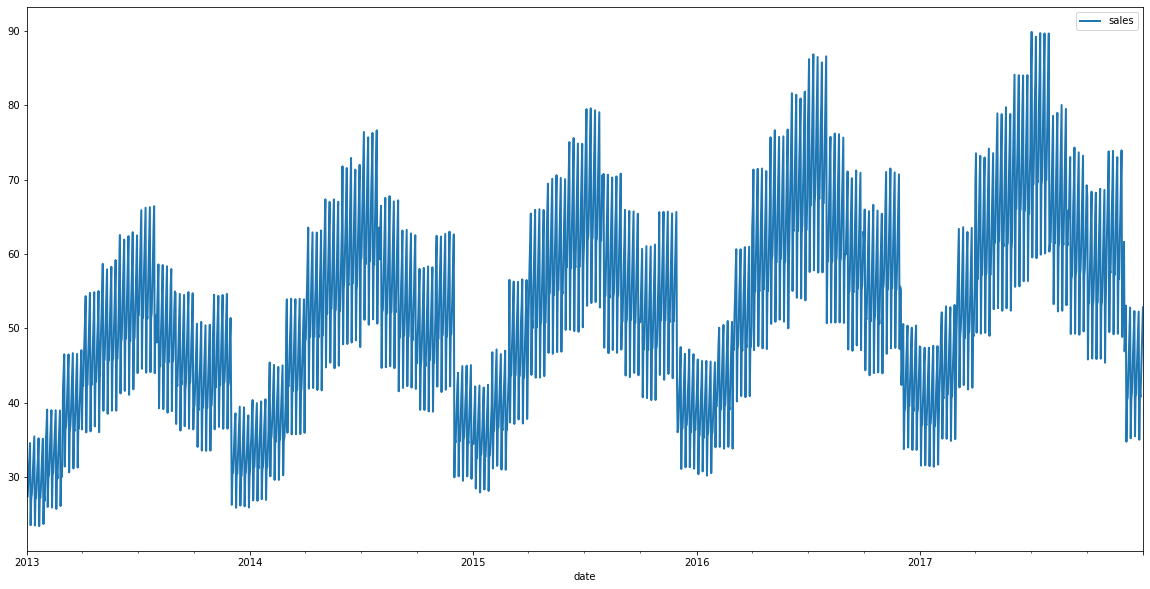

In [14]:
sales = train.groupby("date")[["sales"]].mean()
sales.plot(figsize=(20,10),linewidth=2)

<AxesSubplot:xlabel='date'>

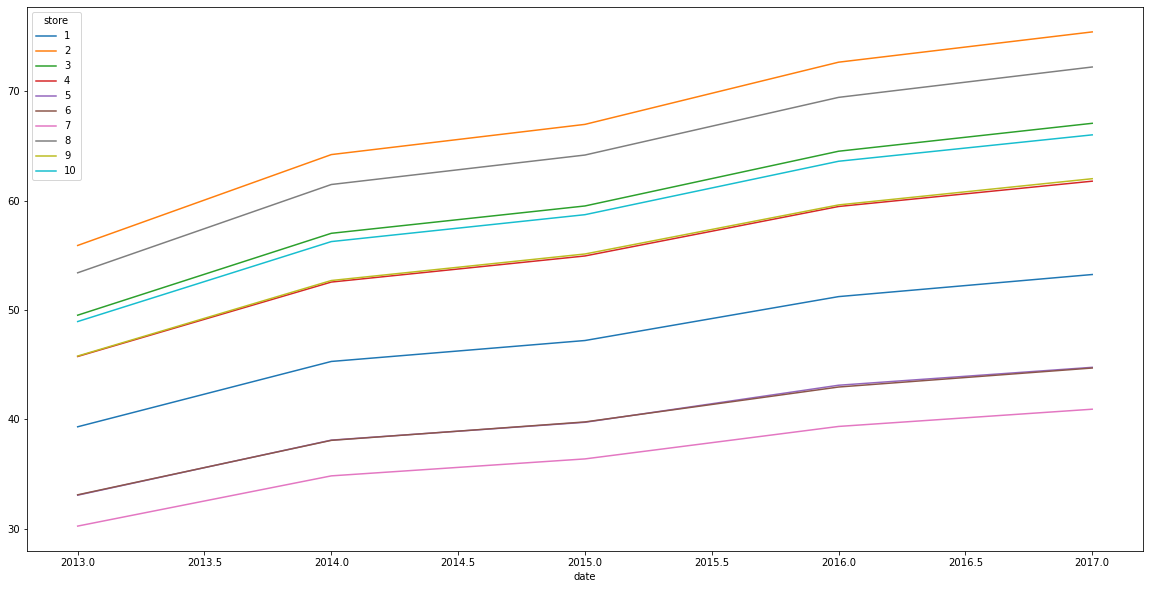

In [15]:
train["date"] = pd.to_datetime(train["date"])
store = train.groupby(by=["store", train["date"].dt.year])[["sales"]].mean().reset_index()
store.pivot(index="date", columns="store", values="sales").plot(figsize=(20,10))

<AxesSubplot:xlabel='date'>

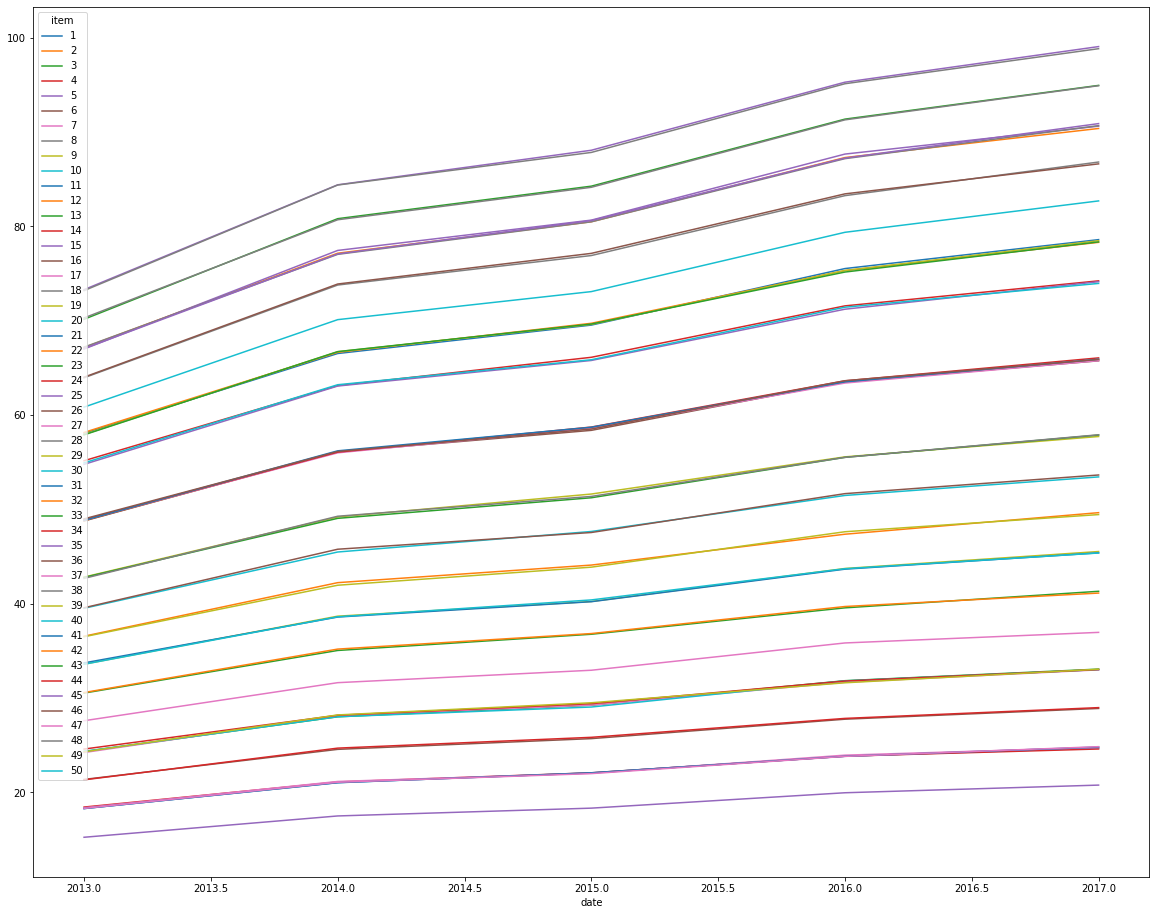

In [16]:
item = train.groupby(by=["item", train["date"].dt.year])[["sales"]].mean().reset_index()
item.pivot(index="date", columns="item", values="sales").plot(figsize=(20,16))

In [17]:
train = train[(train['date'] >= '2017-01-01')]

In [18]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


In [19]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


In [21]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [22]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [23]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,...,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,...,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,...,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,...,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,...,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62.0


In [24]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [26]:
epochs = 25
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [27]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [28]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/25
3149/3149 - 27s - loss: 423.0110 - val_loss: 396.3127 - 27s/epoch - 9ms/step
Epoch 2/25
3149/3149 - 20s - loss: 392.7903 - val_loss: 385.9313 - 20s/epoch - 6ms/step
Epoch 3/25
3149/3149 - 19s - loss: 382.7832 - val_loss: 384.5888 - 19s/epoch - 6ms/step
Epoch 4/25
3149/3149 - 20s - loss: 375.0892 - val_loss: 372.1966 - 20s/epoch - 6ms/step
Epoch 5/25
3149/3149 - 20s - loss: 370.6980 - val_loss: 385.2466 - 20s/epoch - 6ms/step
Epoch 6/25
3149/3149 - 19s - loss: 367.0299 - val_loss: 362.0146 - 19s/epoch - 6ms/step
Epoch 7/25
3149/3149 - 19s - loss: 366.5901 - val_loss: 361.5050 - 19s/epoch - 6ms/step
Epoch 8/25
3149/3149 - 20s - loss: 365.0969 - val_loss: 364.0771 - 20s/epoch - 6ms/step
Epoch 9/25
3149/3149 - 21s - loss: 363.9384 - val_loss: 359.8153 - 21s/epoch - 7ms/step
Epoch 10/25
3149/3149 - 20s - loss: 362.8576 - val_loss: 359.6594 - 20s/epoch - 6ms/step
Epoch 11/25
3149/3149 - 20s - loss: 362.5385 - val_loss: 358.7402 - 20s/epoch - 6ms/step
Epoch 12/25
3149/3149 - 20s - 

In [29]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [30]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/25
3149/3149 - 90s - loss: 2299.4534 - val_loss: 685.4418 - 90s/epoch - 28ms/step
Epoch 2/25
3149/3149 - 74s - loss: 585.5981 - val_loss: 555.7110 - 74s/epoch - 24ms/step
Epoch 3/25
3149/3149 - 73s - loss: 639.3560 - val_loss: 499.3497 - 73s/epoch - 23ms/step
Epoch 4/25
3149/3149 - 76s - loss: 476.6413 - val_loss: 446.3449 - 76s/epoch - 24ms/step
Epoch 5/25
3149/3149 - 78s - loss: 506.5244 - val_loss: 569.1616 - 78s/epoch - 25ms/step
Epoch 6/25
3149/3149 - 75s - loss: 501.2244 - val_loss: 433.3074 - 75s/epoch - 24ms/step
Epoch 7/25
3149/3149 - 75s - loss: 11692.5801 - val_loss: 494.4732 - 75s/epoch - 24ms/step
Epoch 8/25
3149/3149 - 74s - loss: 498.8750 - val_loss: 481.2742 - 74s/epoch - 23ms/step
Epoch 9/25
3149/3149 - 74s - loss: 648.4448 - val_loss: 572.1464 - 74s/epoch - 23ms/step
Epoch 10/25
3149/3149 - 73s - loss: 972.6577 - val_loss: 522.6874 - 73s/epoch - 23ms/step
Epoch 11/25
3149/3149 - 73s - loss: 493.7557 - val_loss: 470.7181 - 73s/epoch - 23ms/step
Epoch 12/25
3149

In [31]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [32]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [33]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/25
3149/3149 - 60s - loss: 434.7737 - val_loss: 392.8010 - 60s/epoch - 19ms/step
Epoch 2/25
3149/3149 - 42s - loss: 397.8697 - val_loss: 382.5900 - 42s/epoch - 13ms/step
Epoch 3/25
3149/3149 - 32s - loss: 391.0458 - val_loss: 426.5285 - 32s/epoch - 10ms/step
Epoch 4/25
3149/3149 - 32s - loss: 391.4054 - val_loss: 380.2107 - 32s/epoch - 10ms/step
Epoch 5/25
3149/3149 - 32s - loss: 389.8261 - val_loss: 379.4237 - 32s/epoch - 10ms/step
Epoch 6/25
3149/3149 - 32s - loss: 387.3647 - val_loss: 396.2112 - 32s/epoch - 10ms/step
Epoch 7/25
3149/3149 - 32s - loss: 385.7368 - val_loss: 378.3133 - 32s/epoch - 10ms/step
Epoch 8/25
3149/3149 - 32s - loss: 382.8055 - val_loss: 375.5066 - 32s/epoch - 10ms/step
Epoch 9/25
3149/3149 - 33s - loss: 382.9392 - val_loss: 376.0251 - 33s/epoch - 11ms/step
Epoch 10/25
3149/3149 - 32s - loss: 380.2493 - val_loss: 376.6502 - 32s/epoch - 10ms/step
Epoch 11/25
3149/3149 - 32s - loss: 378.9366 - val_loss: 371.8489 - 32s/epoch - 10ms/step
Epoch 12/25
3149/31

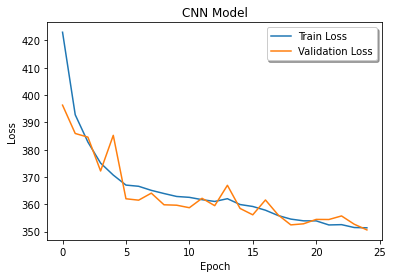

In [34]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

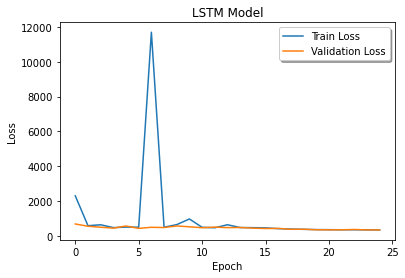

In [35]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

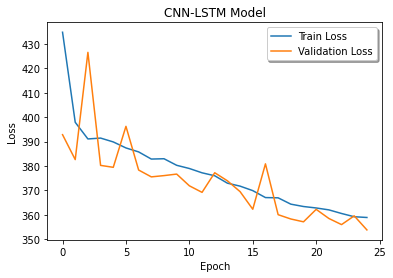

In [36]:
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('CNN-LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

In [37]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

2099/2099 [==============================] - 8s 4ms/step
Train rmse: 18.64579068470171
Validation rmse: 18.72454002168749


In [38]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

2099/2099 [==============================] - 7s 3ms/step
Train rmse: 18.479457044504002
Validation rmse: 18.72454002168749


In [39]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

2099/2099 [==============================] - 10s 5ms/step
Train rmse: 18.813959787807295
Validation rmse: 18.808783422161227
